In [1]:
from utils import *

In [2]:
data=pd.read_fwf("Treasury.txt", delimiter="   ",header=None)
data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,94.960,12.02,12.85,12.11,12.10,10.75,10.52,1130.9,105.6,257.1,14.04,383.1,274.4,868.1,193.0,13.34
1,94.227,11.90,12.90,11.94,11.72,10.69,10.54,1133.6,105.9,258.8,13.94,385.1,276.1,869.8,192.5,13.30
2,94.469,11.92,12.87,11.90,11.91,10.78,10.64,1136.7,106.0,258.1,13.91,384.4,275.3,872.4,191.6,13.21
3,94.685,12.11,12.89,12.19,12.17,10.96,10.87,1137.2,106.1,260.2,13.77,387.1,277.8,872.0,193.6,13.29
4,94.939,12.36,12.85,12.04,12.15,11.24,11.15,1138.3,106.5,262.8,13.54,390.3,280.5,873.0,190.5,13.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044,92.473,6.03,8.15,5.36,5.26,6.39,6.46,4773.5,530.4,337.1,4.72,118.5,579.7,512.9,735.2,5.70
1045,92.767,6.12,8.18,5.24,5.26,6.48,6.56,4794.8,524.7,345.6,5.62,120.6,587.7,532.6,737.8,5.72
1046,93.137,6.13,8.26,5.35,5.31,6.53,6.65,4796.6,522.3,348.0,5.59,120.7,590.3,535.5,743.2,5.74
1047,93.227,6.17,8.25,5.39,5.41,6.54,6.63,4809.2,520.7,345.1,5.43,115.3,586.6,543.4,737.0,5.78


In [3]:
data.shape

(1049, 16)

In [4]:
X= data.iloc[:,:-1].values
y= data.iloc[:,-1].values

findfont: Font family ['times new roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['times new roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['times new roman'] not found. Falling back to DejaVu Sans.


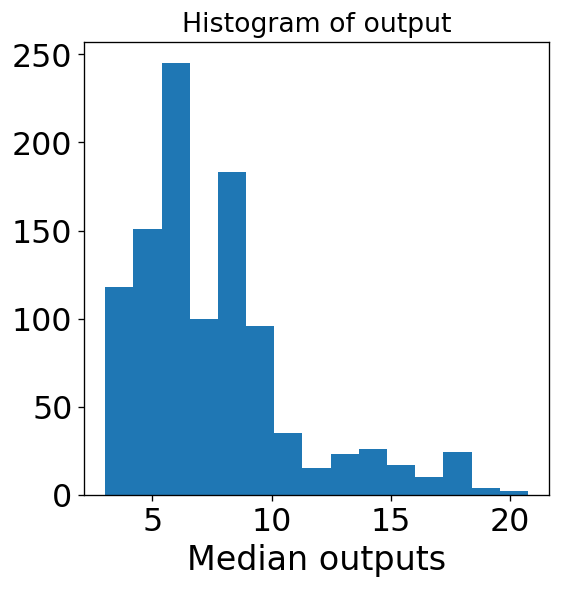

In [8]:
from matplotlib.ticker import FormatStrFormatter
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.hist(y, bins=15)
axs.set_xlabel("Median outputs")
axs.set_title("Histogram of output")
axs.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.show()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_train.shape: (839, 15)
y_train.shape: (839,)
X_test.shape: (210, 15)
y_test.shape: (210,)


In [14]:
#Scaling Transform
scaler = StandardScaler()

#PolynomialTransform
poly=PolynomialFeatures()

# Polynomial Ridge Regression model
reg=Ridge()
polyn_model = Pipeline([("scaler",scaler), ("poly", poly),("reg", reg)])

# Hyperparameter Optimization

#parameters of pipelines can be set using '__'separated parameter names:
param_grid=[
    {#Hyperparameter tuning in Polynomial Ridge Regression
    "poly__degree": [2,3,4,5],,                #[2,3,4,5],
    "reg__alpha": np.logspace(-3,3,7),           #np.logspace(-3,3,7),
    },
]
models = [polyn_model] 
names=['polyn_model'] 
search_bestparams={}
for i,( name, model) in enumerate(zip(names, models)):
    search = GridSearchCV(model, param_grid[i], cv=5, scoring = 'explained_variance')
    search.fit(X_train, y_train)
    a=search.best_params_
    search_bestparams[name]=a

print("best parameters:",search_bestparams)

# ( base algorithm = Polynomial Ridge Regression)
poly = PolynomialFeatures(degree = search_bestparams['polyn_model']['poly__degree'])
reg = Ridge(alpha = search_bestparams['polyn_model']['reg__alpha'])
polyn_model = Pipeline([("scaler",scaler), ("poly", poly),("reg", reg)])

best parameters: {'polyn_model': {'poly__degree': 2, 'reg__alpha': 1}}


In [1]:
#We can have many target coverage levels and save results! Here, we only set coverage level as 95%!
levels=[0.1,0.05,0.01]   #three target quantiles:0.1,0.05,0.01  , #three target coverage levels:90% , 95%, 99%
funcs=[jackknife,jackknife_plus, weighted_jackknife_plus,CV,CV_plus, weighted_CV_plus] #[jackknife,jackknife_plus, weighted_jackknife_plus,
names=['J','J+','WJ+','CV', 'CV+', 'WCV+']
results={}

for name, func in zip(names,funcs):
    res=[]
    for level in levels:
        result=func(X_train,y_train,X_test,y_test,alpha=level) 
        res.append(result)
    results[name]=res
results

In [18]:
results['CV'][1][0][1],results['CV'][1][0][2]

(0.943, 0.109)

In [20]:
d=results
a=pd.DataFrame(list(zip(y_test,
                        d['J'][0][0][3][:,0], d['J'][0][0][3][:,1],
                        d['J'][1][0][3][:,0], d['J'][1][0][3][:,1],
                        d['J'][2][0][3][:,0], d['J'][2][0][3][:,1],
                        d['J+'][0][0][3][:,0], d['J+'][0][0][3][:,1],
                        d['J+'][1][0][3][:,0], d['J+'][1][0][3][:,1],
                        d['J+'][2][0][3][:,0], d['J+'][2][0][3][:,1],
                        d['WJ+'][0][0][3][:,0],d['WJ+'][0][0][3][:,1],
                        d['WJ+'][1][0][3][:,0],d['WJ+'][1][0][3][:,1],
                        d['WJ+'][2][0][3][:,0],d['WJ+'][2][0][3][:,1],

                        d['CV'][0][0][3][:,0], d['CV'][0][0][3][:,1],
                        d['CV'][1][0][3][:,0], d['CV'][1][0][3][:,1],
                        d['CV'][2][0][3][:,0], d['CV'][2][0][3][:,1],
                        d['CV+'][0][0][3][:,0], d['CV+'][0][0][3][:,1],
                        d['CV+'][1][0][3][:,0], d['CV+'][1][0][3][:,1],
                        d['CV+'][2][0][3][:,0], d['CV+'][2][0][3][:,1],
                        d['WCV+'][0][0][3][:,0],d['WCV+'][0][0][3][:,1],
                        d['WCV+'][1][0][3][:,0],d['WCV+'][1][0][3][:,1],
                        d['WCV+'][2][0][3][:,0],d['WCV+'][2][0][3][:,1],                        
                       )),
               columns=['y_test',
                        'j_10low','j_10up',
                        'j_5low','j_5up',
                        'j_1low','j_1up',
                        'j_P_10low','j_P_10up',
                        'j_P_5low','j_P_5up',
                        'j_P_1low','j_P_1up',
                        'Wj_10low','Wj_10up',
                        'Wj_5low','Wj_5up',
                        'Wj_1low','Wj_1up',
                        
                        'CV_10low','CV_10up',
                        'CV_5low','CV_5up',
                        'CV_1low','CV_1up',                   
                        'CV_P_10low','CV_P_10up',
                        'CV_P_5low','CV_P_5up',
                        'CV_P_1low','CV_P_1up',
                        'WCV_10low','WCV_10up',
                        'WCV_5low','WCV_5up',
                        'WCV_1low','WCV_1up',
                       ])
a

,y_test,j_10low,j_10up,j_5low,j_5up,j_1low,j_1up,j_P_10low,j_P_10up,j_P_5low,...,CV_P_5low,CV_P_5up,CV_P_1low,CV_P_1up,WCV_10low,WCV_10up,WCV_5low,WCV_5up,WCV_1low,WCV_1up
0,0.769748,0.738690,0.812237,0.720866,0.830061,0.648512,0.902415,0.738700,0.812486,0.720290,...,0.714590,0.830693,0.0,0.922557,0.749489,0.800702,0.718628,0.819452,0.0,1.216450
1,0.671369,0.655956,0.729503,0.638131,0.747327,0.565778,0.819681,0.655983,0.729466,0.637006,...,0.631065,0.746580,0.0,0.832497,0.669382,0.712815,0.613017,0.741565,0.0,1.092483
2,0.700617,0.669925,0.743472,0.652101,0.761296,0.579747,0.833650,0.669953,0.743501,0.651912,...,0.646123,0.761518,0.0,0.849412,0.685315,0.725901,0.669863,0.740237,0.0,0.895344
3,0.693969,0.685948,0.759495,0.668124,0.777320,0.595770,0.849673,0.686044,0.759526,0.667020,...,0.661396,0.775530,0.0,0.860685,0.697098,0.743729,0.637469,0.776963,0.0,1.154502
4,1.217770,1.206727,1.280275,1.188903,1.298099,1.116550,1.370452,1.206722,1.280269,1.189264,...,1.180302,1.298141,0.0,1.388856,1.214918,1.267952,1.150312,1.297545,0.0,1.881957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,0.408139,0.371672,0.445219,0.353847,0.463043,0.281494,0.535397,0.371657,0.445228,0.353857,...,0.347693,0.462727,0.0,0.553377,0.391545,0.423635,0.362195,0.442256,0.0,0.634342
206,1.114074,1.064408,1.137955,1.046583,1.155779,0.974230,1.228133,1.064331,1.138150,1.046022,...,1.041094,1.154992,0.0,1.247009,1.080318,1.118244,1.013512,1.157092,0.0,1.351865
207,0.977141,0.949439,1.022986,0.931615,1.040810,0.859261,1.113164,0.949171,1.023018,0.931848,...,0.922913,1.040580,0.0,1.131295,0.948319,1.016821,0.902224,1.053157,0.0,1.396765
208,0.640792,0.599137,0.672684,0.581313,0.690508,0.508959,0.762862,0.599028,0.673179,0.581320,...,0.575310,0.690322,0.0,0.783111,0.618609,0.652658,0.600416,0.665878,0.0,1.152111


In [21]:
a_sort=a.sort_values(by=['y_test'])
y_test=a_sort.y_test.values
r={}
r['J']=np.array(a_sort[['j_5low','j_5up']])
r['J+']=np.array(a_sort[['j_P_5low','j_P_5up']])
r['WJ+']=np.array(a_sort[['Wj_5low','Wj_5up']])
r['CV']=np.array(a_sort[['CV_5low','CV_5up']])
r['CV+']=np.array(a_sort[['CV_P_5low','CV_P_5up']])
r['WCV+']=np.array(a_sort[['WCV_5low','WCV_5up']])
coverage={}
width={}
names=['J','J+','WJ+','CV' , 'CV+' ,'WCV+']
for name in names:
    coverage[name] = round(regression_coverage_score(
                    y_test,r[name][:,0], r[name][:,1]
                ),3)
    width[name]=(r[name][:,1] - r[name][:,0]).mean().round(3)

In [22]:
def plot(
    title,
    axs,
    y_test_sorted,
    y_pred_sorted,
    lower_bound,
    upper_bound,
    coverage,
    width,
#     missed,
    num_plots_idx
):
    """
    Plot of the prediction intervals for each different conformal
    method.
    """
    axs.yaxis.set_major_formatter(FormatStrFormatter('%.2f' )) #'%.0f'
    axs.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    lower_bound_ = np.take(lower_bound, num_plots_idx)
    y_pred_sorted_ = np.take(y_pred_sorted, num_plots_idx)
    y_test_sorted_ = np.take(y_test_sorted, num_plots_idx)

    error = y_pred_sorted_-lower_bound_

    warning1 = y_test_sorted_ > y_pred_sorted_+error
    warning2 = y_test_sorted_ < y_pred_sorted_-error
    warnings = warning1 + warning2
    axs.errorbar(
        y_test_sorted_[~warnings],
        y_pred_sorted_[~warnings],
        yerr=error[~warnings],
        capsize=2, marker="o", elinewidth=1, linewidth=0,ecolor='lightgray',color='lightgray',
        label="Inside prediction interval"
        )
    axs.errorbar(
        y_test_sorted_[warnings],
        y_pred_sorted_[warnings],
        yerr=error[warnings],
        capsize=5, marker="o", elinewidth=4, linewidth=0, color="red",
        label="Outside prediction interval"
        )
    axs.scatter(
        y_test_sorted_[warnings],
        y_test_sorted_[warnings],
        s=40,marker="*", color="green",
        label="True value"
    )

    lims = [
        np.min([axs.get_xlim(), axs.get_ylim()]),  # min of both axes
        np.max([axs.get_xlim(), axs.get_ylim()]),  # max of both axes

    ]
    axs.plot(lims, lims, '--', alpha=0.75, color="black", label="x=y")
    axs.set_title(title+  ("(%s, %s)" % (coverage, width)),fontweight ='bold', fontsize = 25)
    axs.set( adjustable='box',aspect='equal') #adjustable='box',


findfont: Font family ['times new roman'] not found. Falling back to DejaVu Sans.


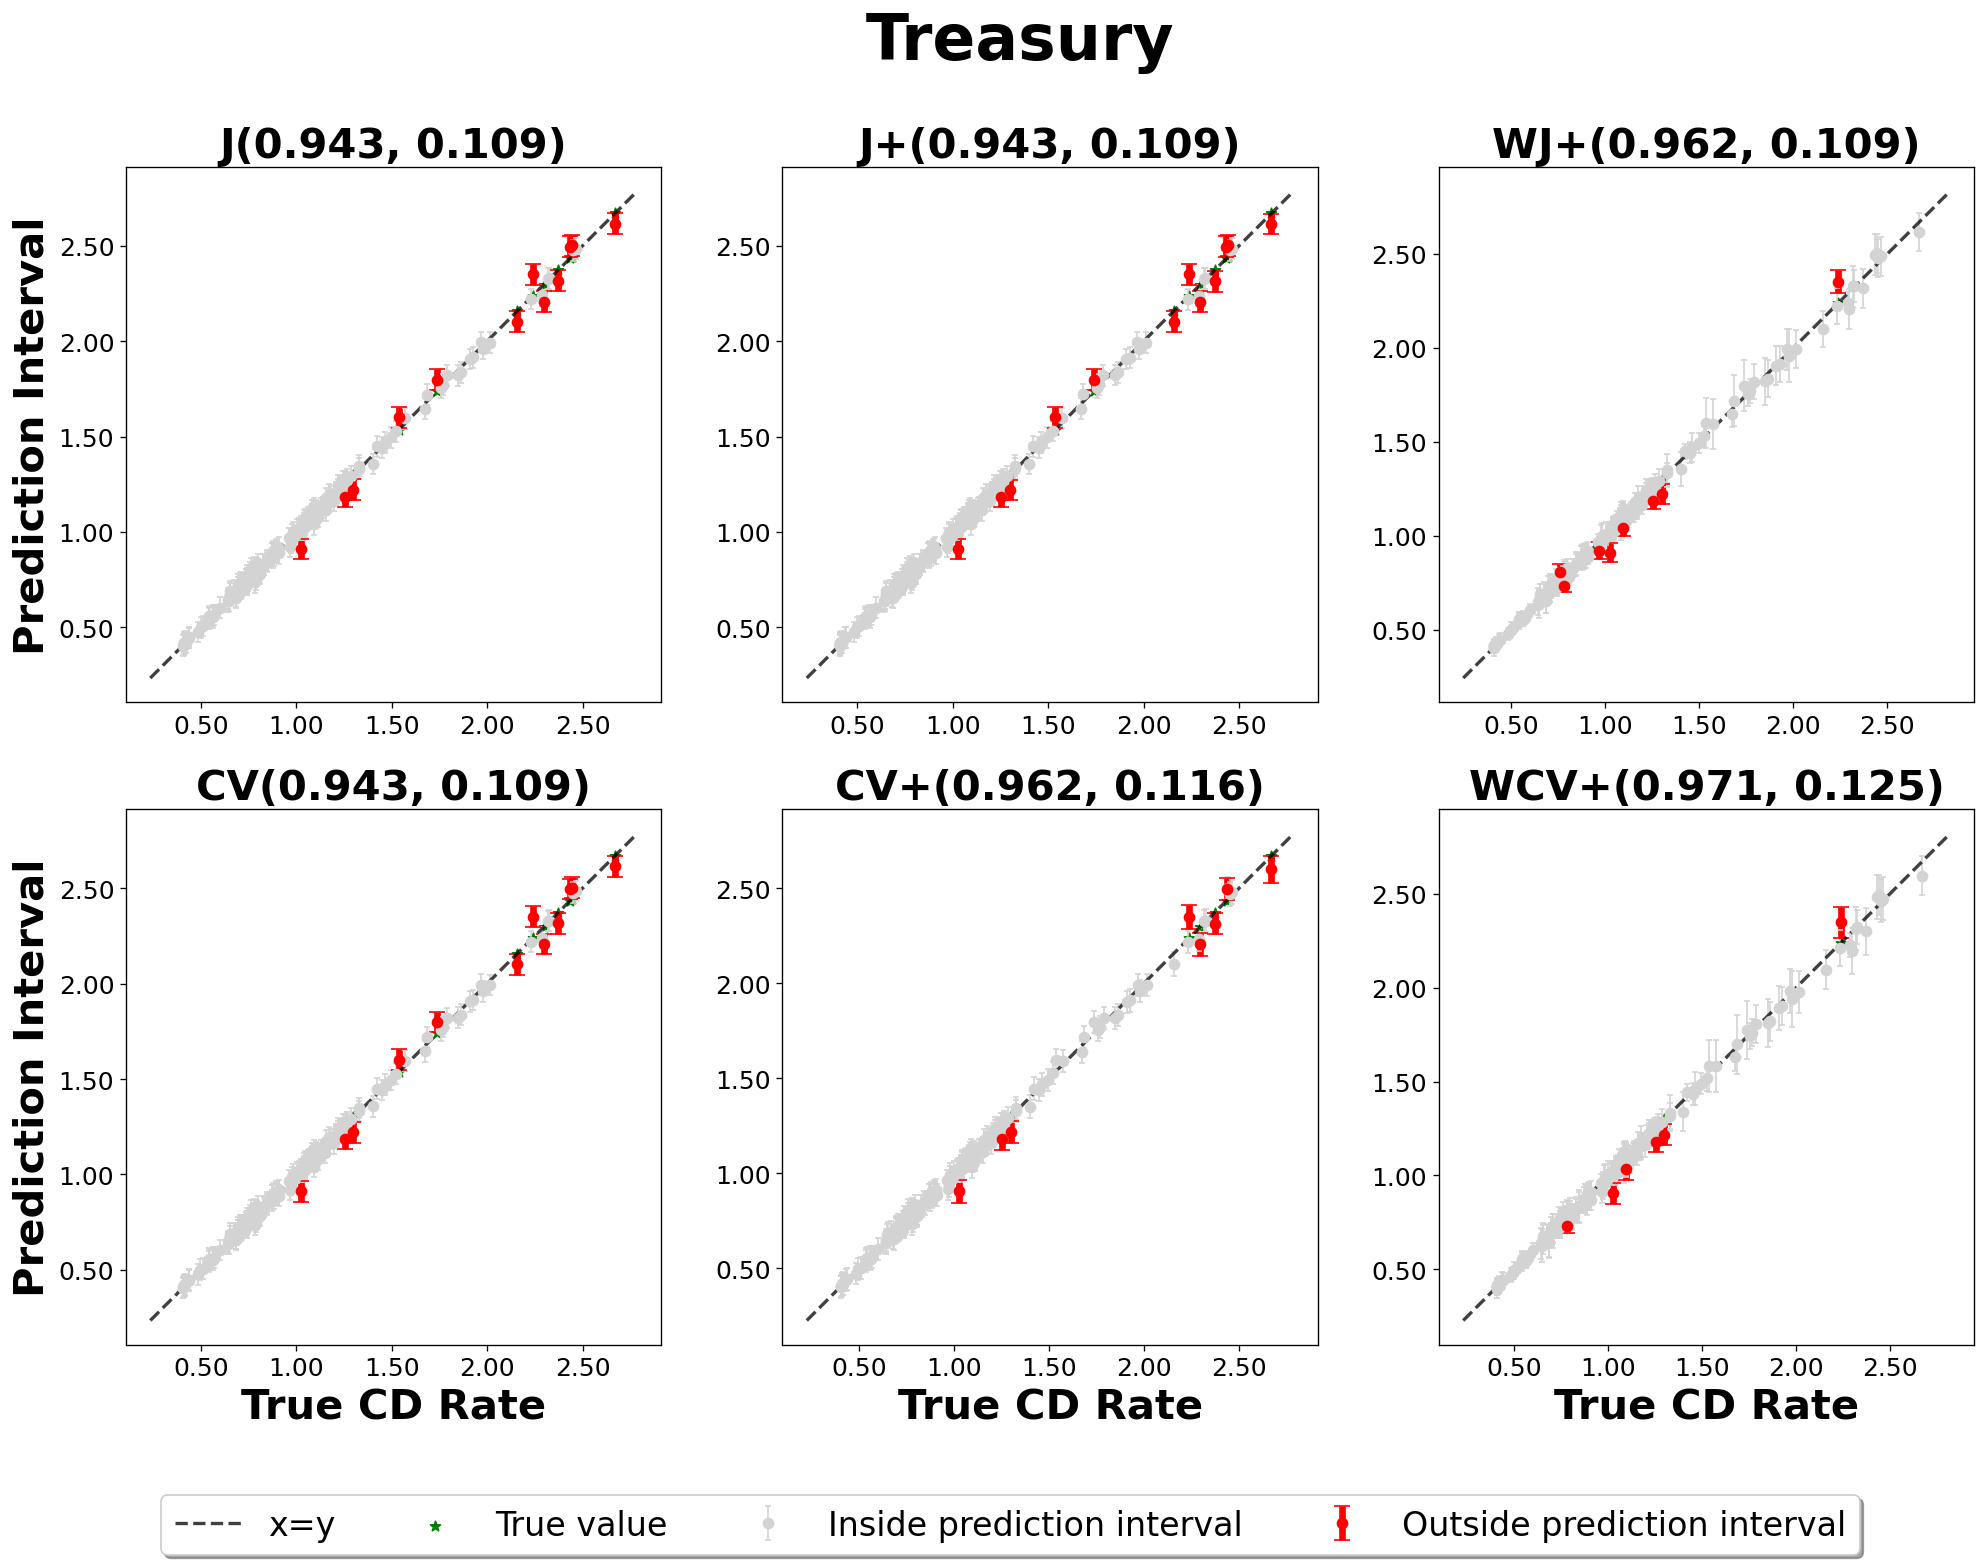

In [23]:
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
perc_obs_plot =1
num_plots = rng.choice(
    len(y_test), int(perc_obs_plot*len(y_test)), replace=False
    )
fig, axs = plt.subplots(2, 3, figsize=(20, 13))
coords = [axs[0, 0], axs[0, 1], axs[0, 2], axs[1, 0], axs[1, 1], axs[1, 2]]
# for strategy, coord in zip(STRATEGIES.keys(), coords):
for i,(name, coord) in enumerate(zip(names, coords)):
    plot(
        name,
        coord,
        y_test,
        r[name].mean(axis=1).ravel(),
        r[name][:,0],
        r[name][:,1],
        coverage[name],
        width[name],
#         missed[name],
        num_plots
        )
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(_, []) for _ in zip(*lines_labels)]
plt.legend(
    lines[:4], labels[:4],
    loc='upper center',
    bbox_to_anchor=(-0.8,-0.25 ),
    fancybox=True,
    shadow=True,
    ncol=4,fontsize = 20,
)

axs[0,0].set_ylabel("Prediction Interval",fontweight ='bold', fontsize = 25)
axs[1,0].set_ylabel("Prediction Interval",fontweight ='bold', fontsize = 25)
axs[1,0].set_xlabel("True CD Rate",fontweight ='bold', fontsize = 25)
axs[1,1].set_xlabel("True CD Rate",fontweight ='bold', fontsize = 25)
axs[1,2].set_xlabel("True CD Rate",fontweight ='bold', fontsize = 25)
fig.suptitle("Treasury",fontweight ='bold',fontsize=38)
plt.show()

In [24]:
y_test.min(),y_test.max()

(0.406809690616081, 2.6695224142388585)

# Confidence Level=95%

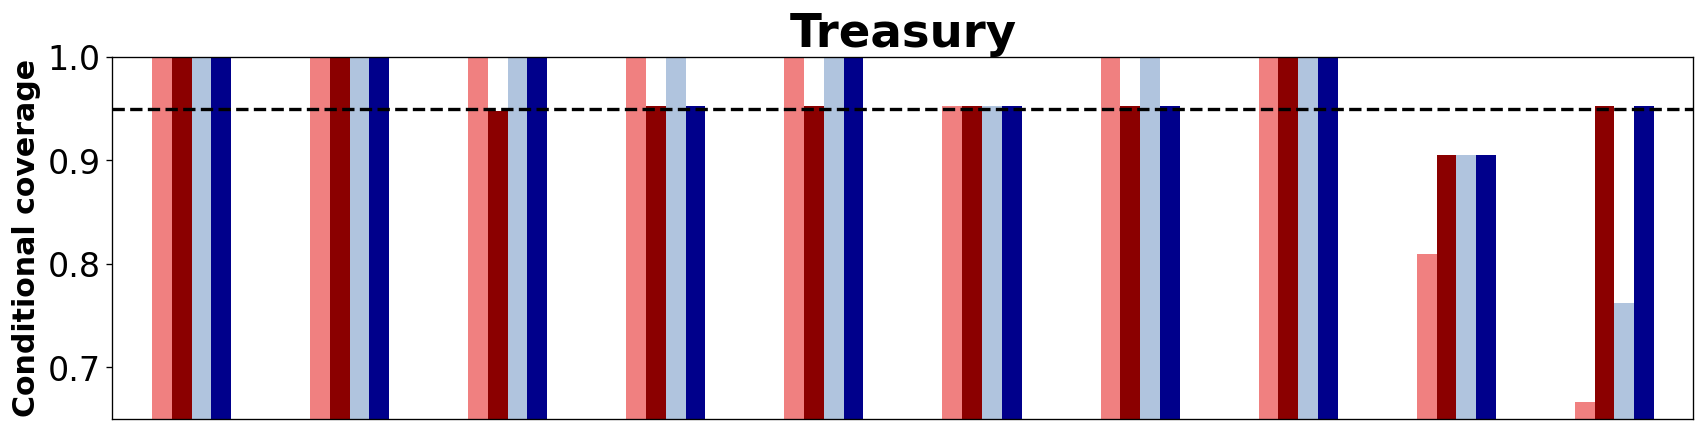

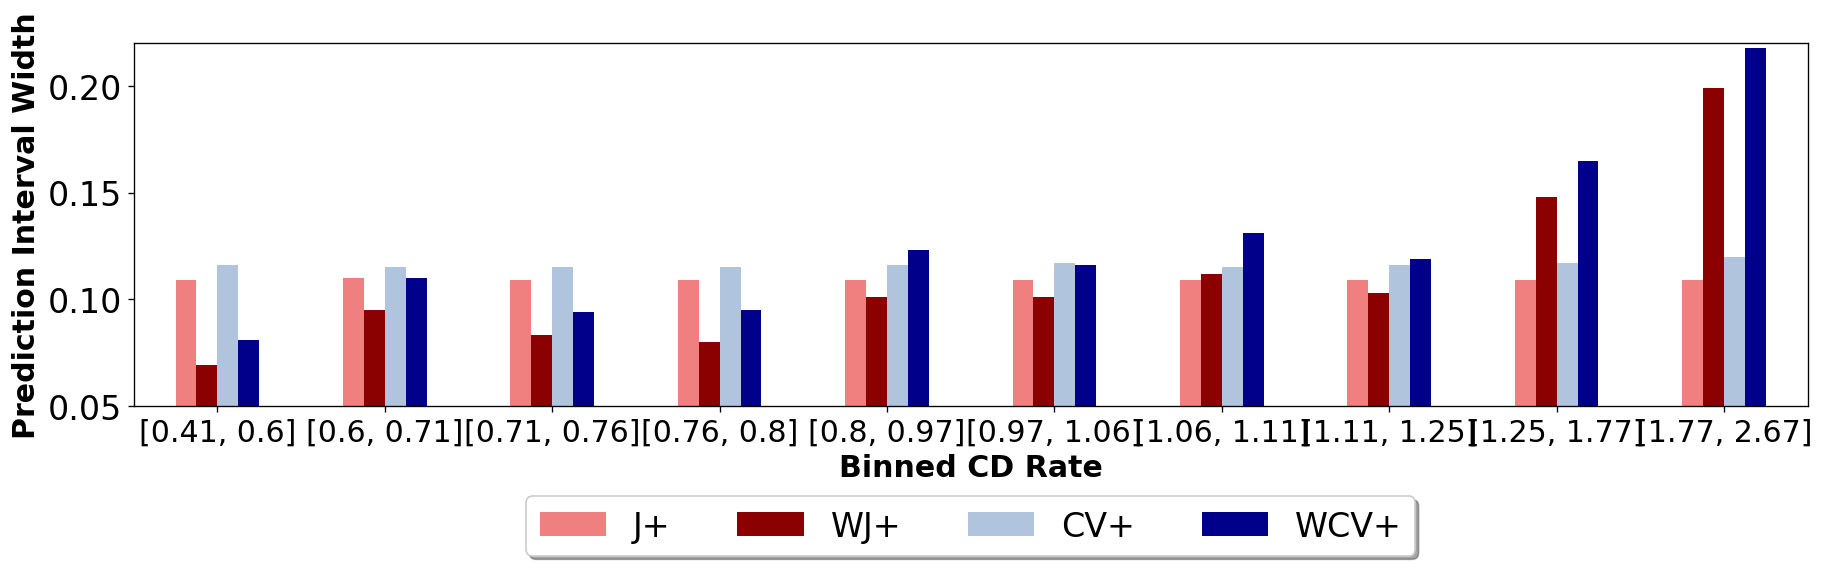

In [38]:
y_test=a_sort.y_test.values
r={}
r['J']=np.array(a_sort[['j_5low','j_5up']])
r['J+']=np.array(a_sort[['j_P_5low','j_P_5up']])
r['WJ+']=np.array(a_sort[['Wj_5low','Wj_5up']])
r['CV']=np.array(a_sort[['CV_5low','CV_5up']])
r['CV+']=np.array(a_sort[['CV_P_5low','CV_P_5up']])
r['WCV+']=np.array(a_sort[['WCV_5low','WCV_5up']])
names=['J+','WJ+','CV+' ,'WCV+']
def bins_cov(want,y_test, r, a_sort, names, bins):
    cuts = []
    cuts_ = pd.qcut(y_test, bins).unique()[:-1]
    for item in cuts_:
        cuts.append(item.left)
    cuts.append(cuts_[-1].right)
    cuts.append(np.max(y_test))#+1
    
    recap = {}
    for i in range(len(cuts)-1):
        cut1, cut2 = cuts[i], cuts[i+1]
        name = f"[{np.round(cut1, 2)}, {np.round(cut2, 2)}]"
        recap[name] = []
        for strategy in names:
            indices = np.where((y_test >= cuts[i]) * (y_test <= cuts[i+1]))
            y_test_trunc = np.take(y_test, indices)
            y_low_ = np.take(r[strategy][:,0], indices)
            y_high_ = np.take(r[strategy][:,1], indices)
            score_coverage = regression_coverage_score(
                y_test_trunc[0], y_low_[0], y_high_[0]
            )
            width=( y_high_[0] - y_low_[0]).mean().round(3)
            if want == "coverage":
                recap[name].append(score_coverage)
            elif want == "width":
                recap[name].append(width)
    recap_df = pd.DataFrame(recap, index=names)
    return recap_df
bins = list(np.arange(0, 1, 0.1))
mpl.rc('ytick', labelsize=20)
binned_data = bins_cov(
    "coverage",
    y_test, r, a_sort, names, bins
)
binned_data.T.plot.bar(figsize=(17, 4), color=['lightcoral','darkred','lightsteelblue','darkblue'])
plt.axhline(0.95, ls="--", color="k")
plt.ylabel("Conditional coverage",fontweight ='bold',fontsize=18)
plt.title("Treasury",fontweight ='bold',fontsize=28)
plt.xticks([])
plt.ylim(0.65, 1.0)
legend = plt.legend(handles=[], labels= [])
legend.remove()
plt.show()
mpl.rc('ytick', labelsize=20)
mpl.rc('xtick', labelsize=15)
binned_data = get_coverages_widths_by_bins(
    "width",
    y_test, r, a_sort, names, bins
)
binned_data.T.plot.bar(figsize=(18, 4), color=['lightcoral','darkred','lightsteelblue','darkblue'])
plt.ylabel("Prediction Interval Width",fontweight ='bold',fontsize=18)
plt.xlabel("Binned CD Rate",fontweight ='bold',fontsize=18)
plt.xticks(rotation=0,fontsize=18)
plt.ylim(0.05, 0.22)
lines, labels = fig.axes[0].get_legend_handles_labels() 
plt.legend( loc='upper center', bbox_to_anchor=(0.5, -0.25),
              fancybox=True, shadow=True, ncol=6,fontsize=20, borderaxespad=0.)
plt.show()